# Assignment 11: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [13]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm_notebook

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, KFold, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from joblib import dump, load

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [15]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
%cd /gdrive/My Drive/Appliedai colab/donors choose data/

/gdrive/My Drive/Appliedai colab/donors choose data


In [0]:
%cd /demo-mount/donors choose data

/demo-mount/donors choose data


In [0]:
# sample_data = {'State':['A','B','C','A','A','B','A','A','C','C'], 'class':[0,1,1,0,1,1,0,1,1,0]}
# df_sample = pd.DataFrame(sample_data)
# X_sample = df_sample[['State']] #2 square brackets selects single column as a dataframe rather than a series
# y_sample = df_sample[['class']].values

In [0]:
# # alpha is used for laplace smoothing
# feature = 'State'
# alpha = 0
# response_array = response_coding(alpha, feature, X_sample, y_sample)
# response_coded_df = rc_df(response_array, feature)
# response_coded_df

In [0]:
def roc_auc_pipe(clf, X_train, X_test, y_train, y_test, title):
  y_train_pred = clf.predict_proba(X_train)[:,1]
  y_test_pred = clf.predict_proba(X_test)[:,1]
      
  train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

  plt.close
  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.plot([0, 1], [0, 1],'g--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title(title)
  plt.grid()
  plt.show()

In [0]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [0]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean test score: {0:.8f} (std: {1:.8f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

<h1>1. GBDT (xgboost/lightgbm/catboost) </h1>

## 1.1 Loading Data

In [20]:
data = pd.read_csv('preprocessed_final.csv', nrows = 50000)
data = data.drop(['teacher_id','Unnamed: 0','std_price','nrm_price'], axis =1)
data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.60,23
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.00,1
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,"My students need shine guards, athletic socks,...",1,0,"\r\n\""True champions aren't always the ones th...",516.85,22
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,Techie Kindergarteners,My students need to engage in Reading and Math...,4,1,I work at a unique school filled with both ESL...,232.90,4
4,mrs,tx,grades_prek_2,math_science,mathematics,Interactive Math Tools,My students need hands on practice in mathemat...,1,1,Our second grade classroom next year will be m...,67.98,4


In [0]:
# %%time
# # sentiment Score of essay
# data = data.merge(data.essay.apply(lambda s: pd.Series({'neg':sid.polarity_scores(s)['neg'], 
#                                                  'neu':sid.polarity_scores(s)['neu'],
#                                                  'pos':sid.polarity_scores(s)['pos'],
#                                                  'compound':sid.polarity_scores(s)['compound']})), 
#            left_index=True, right_index=True)

In [24]:
%%time
from pandarallel import pandarallel #Using pandarallel as it splits data and uses all cores
# Initialization
pandarallel.initialize() #(progress_bar=True)
# sentiment Score of essay
data = data.merge(data.essay.parallel_apply(lambda s: pd.Series({'neg':sid.polarity_scores(s)['neg'], 
                                                 'neu':sid.polarity_scores(s)['neu'],
                                                 'pos':sid.polarity_scores(s)['pos'],
                                                 'compound':sid.polarity_scores(s)['compound']})), 
           left_index=True, right_index=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 464 ms, sys: 601 ms, total: 1.07 s
Wall time: 8min 57s


Create a transformer that'll take all categorical rows, encode them to response_coding, concats the rows and deletes the Original rows.

In [0]:
#https://github.com/Lalit-Yadav-E1483/ml_case_studies/blob/7da02bdef5512c6ab636727a2a589072b0e2d515/cancer_diagnosis/initial_analysis.ipynb
def response_table(alpha, feature, X, y):
    value_count = X[feature].value_counts()
    gv_dict = dict()
    y_series = y

    for i, denominator in value_count.items():
        vec = []
        for k in range(len(np.unique(y))):
            cls_cnt = X.loc[(pd.Series(y.flatten()) == k) & (X[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict, y_series, value_count

def response_coding(alpha, feature, X, y):
    gv_dict, y_series, value_count = response_table(alpha, feature, X, y)

    gv_fea = []
    for index, row in X.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/y_series.unique().size for _ in range(y_series.unique().size)])
    return np.array(gv_fea)

def rc_df(response_array, feature):
  response_coded_df = pd.DataFrame()
  for i in range(response_array.shape[1]):
    name = feature + '_' + str(i)
    response_coded_df[name] = response_array[:,i]
  return response_coded_df

In [0]:
#Custom Transformer that returns passed column as response coding and deletes the original column
from sklearn.base import BaseEstimator, TransformerMixin

class response_coding_transformer( BaseEstimator, TransformerMixin ):
  #Class Constructor
  def __init__( self, feature):
    self._feature = feature

  #Return self nothing else to do here    
  def fit( self, X, y):
    self._temp = pd.DataFrame()
    for feature in self._feature:
      alpha = 0
      response_array = response_coding(alpha, feature, X, y)
      response_coded_df = rc_df(response_array, feature)
      self._temp = pd.concat([self._temp, response_coded_df], axis=1)
    self.new_x = X.drop(self._feature, axis = 1)
    return self.new_x
  
  #Method that describes what we need this transformer to do
  def transform( self, X):
    return pd.concat([self.new_x, self._temp], axis=1)

In [0]:
X = data.drop('project_is_approved', axis =1)
y = data['project_is_approved'].values
categorical_features = ['school_state', 'teacher_prefix', 'project_grade_category','project_subject_categories','project_subject_subcategories']

In [28]:
%%time
rc = response_coding_transformer(categorical_features)
rc.fit(X, y)
X_resp_coded = rc.transform(X)

CPU times: user 3min 32s, sys: 56.5 ms, total: 3min 33s
Wall time: 3min 33s


In [0]:
text_transformer = TfidfVectorizer(stop_words = 'english', min_df = 10)

numeric_features = ['teacher_number_of_previously_posted_projects', 'price']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

text_transformer = Pipeline(steps=[
    ('trans', text_transformer)])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
        ('essay', text_transformer, "essay"),
        ('title', text_transformer, "project_title"),
        ('summary', text_transformer, "project_resource_summary")]
        ,n_jobs=-1, verbose=True, remainder = 'passthrough'
            )

In [30]:
X_encoded = preprocessor.fit_transform(X_resp_coded)
X_encoded

<50000x18150 sparse matrix of type '<class 'numpy.float64'>'
	with 6137521 stored elements in Compressed Sparse Row format>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, shuffle=True, stratify=y)

**Set 1:** TFIDF + response coding

categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)

**PIPELINE**

In [0]:
#Handling class-imbalance in XGBoost
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances).
# https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets

pos, neg = data['project_is_approved'].value_counts()
scale_pos_weight = neg/pos

In [0]:
seed = 42
num_folds = 3
cv = StratifiedKFold(n_splits=num_folds, random_state =seed)

In [33]:
%%time 
model = XGBClassifier(objective = 'binary:logistic',
                      random_state = seed, 
                      eval_metric = ["error","auc"],
                      max_depth = 1,
                      n_estimators = 550
                    #  scale_pos_weight = scale_pos_weight
                     )
pipeline = Pipeline(steps=[('classifier',  model)])
pipeline.fit(X_train, y_train);
print("model accuracy score: %.3f" % pipeline.score(X_test, y_test))

model accuracy score: 0.848
CPU times: user 1min 39s, sys: 138 ms, total: 1min 39s
Wall time: 1min 39s


<p style="text-align: center;"> Classification report when not using scale_pos_weight </p>

![image.png](attachment:image.png)

In [34]:
#Classification report with scale_pos_weight
pred_test = pipeline.predict(X_test)
pred_train = pipeline.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8491733333333333
Test Accuraccy:  0.84824

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.03      0.06      1929
           1       0.85      1.00      0.92     10571

    accuracy                           0.85     12500
   macro avg       0.77      0.51      0.49     12500
weighted avg       0.83      0.85      0.78     12500



In [44]:
pred_test1 = np.ones(12500)
pred_train1 = np.ones(37500)

#Classification report with scale_pos_weight
# pred_test = pipeline.predict(X_test)
# pred_train = pipeline.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train1))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test1))
print('\nClassification Report:')
print(classification_report(y_test, pred_test1))

Train Accuracy:  0.8457333333333333
Test Accuraccy:  0.84568

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1929
           1       0.85      1.00      0.92     10571

    accuracy                           0.85     12500
   macro avg       0.42      0.50      0.46     12500
weighted avg       0.72      0.85      0.77     12500



We can see here that the f1-score for class 0 saw a massive increase, whereas for class 1 it decreased a bit.

Your preference would depend for your problem statement and tolerence for FP or FN

**GridSearch**

In [0]:
%%time
param_grid = {
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__n_estimators': [10, 100, 300, 500, 800]
}

gs = GridSearchCV(pipeline, param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1,\
                  verbose=7, return_train_score = True, refit = True)

gs = gs.fit(X_train, y_train)
print(("best score from grid search: %.3f"
       % gs.best_score_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  60 | elapsed:  7.0min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  47 out of  60 | elapsed: 11.4min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  56 out of  60 | elapsed: 15.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.9min finished


best score from grid search: 0.749
CPU times: user 2min 23s, sys: 232 ms, total: 2min 23s
Wall time: 23min 16s


In [0]:
report(gs.cv_results_)

Model with rank: 1
Mean test score: 0.74907915 (std: 0.00601278)
Parameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 800}

Model with rank: 2
Mean test score: 0.74814344 (std: 0.00592829)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 300}

Model with rank: 3
Mean test score: 0.74809877 (std: 0.00500666)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 500}

Model with rank: 4
Mean test score: 0.74617611 (std: 0.00428697)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 800}

Model with rank: 5
Mean test score: 0.74613020 (std: 0.00479112)
Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 300}



In [0]:
results = pd.DataFrame(gs.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.652901,0.017756,0.999644,0.010152,1,10,"{'classifier__max_depth': 1, 'classifier__n_es...",0.661204,0.661319,0.654561,0.659028,0.003159,20,0.666154,0.662709,0.667974,0.665612,0.002183
1,23.025166,0.063628,1.010636,0.006601,1,100,"{'classifier__max_depth': 1, 'classifier__n_es...",0.717915,0.721752,0.709716,0.716461,0.005020,16,0.730527,0.727978,0.735776,0.731427,0.003247
2,63.994698,0.169497,1.053610,0.005355,1,300,"{'classifier__max_depth': 1, 'classifier__n_es...",0.738390,0.745102,0.729923,0.737805,0.006210,14,0.767837,0.765037,0.770712,0.767862,0.002317
3,105.076297,0.241667,1.083008,0.002540,1,500,"{'classifier__max_depth': 1, 'classifier__n_es...",0.745196,0.751680,0.738098,0.744991,0.005547,6,0.787608,0.785302,0.790647,0.787852,0.002189
4,166.383127,0.421355,1.144613,0.003807,1,800,"{'classifier__max_depth': 1, 'classifier__n_es...",0.750155,0.755846,0.741236,0.749079,0.006013,1,0.808964,0.807720,0.812131,0.809605,0.001857
5,8.524284,0.105572,0.994403,0.009857,3,10,"{'classifier__max_depth': 3, 'classifier__n_es...",0.692662,0.697306,0.689204,0.693057,0.003319,19,0.715785,0.710131,0.717288,0.714402,0.003081
6,61.335731,0.189521,1.054602,0.017846,3,100,"{'classifier__max_depth': 3, 'classifier__n_es...",0.741078,0.747685,0.729990,0.739585,0.007301,13,0.811794,0.810175,0.816035,0.812668,0.002471
7,176.685045,1.060497,1.136786,0.013879,3,300,"{'classifier__max_depth': 3, 'classifier__n_es...",0.750705,0.753776,0.739949,0.748143,0.005928,2,0.880768,0.880350,0.884457,0.881859,0.001845
8,290.252226,0.890474,1.218517,0.009880,3,500,"{'classifier__max_depth': 3, 'classifier__n_es...",0.750428,0.752725,0.741143,0.748099,0.005007,3,0.919113,0.918141,0.920866,0.919373,0.001128
9,463.228300,1.724326,1.356300,0.017614,3,800,"{'classifier__max_depth': 3, 'classifier__n_es...",0.747884,0.750360,0.740284,0.746176,0.004287,4,0.953036,0.952743,0.952963,0.952914,0.000124


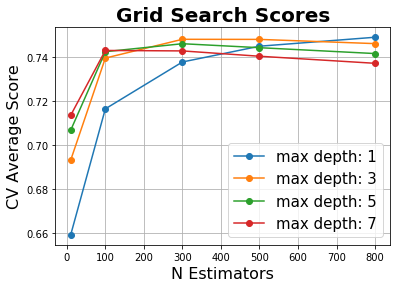

In [0]:
# Calling Method 
max_depth = gs.param_grid['classifier__max_depth']
n_estimators = gs.param_grid['classifier__n_estimators']
plot_grid_search(gs.cv_results_, n_estimators, max_depth, 'N Estimators', 'max depth')

In [0]:
gs.best_params_, gs.best_score_

({'classifier__max_depth': 1, 'classifier__n_estimators': 800},
 0.749079146424645)

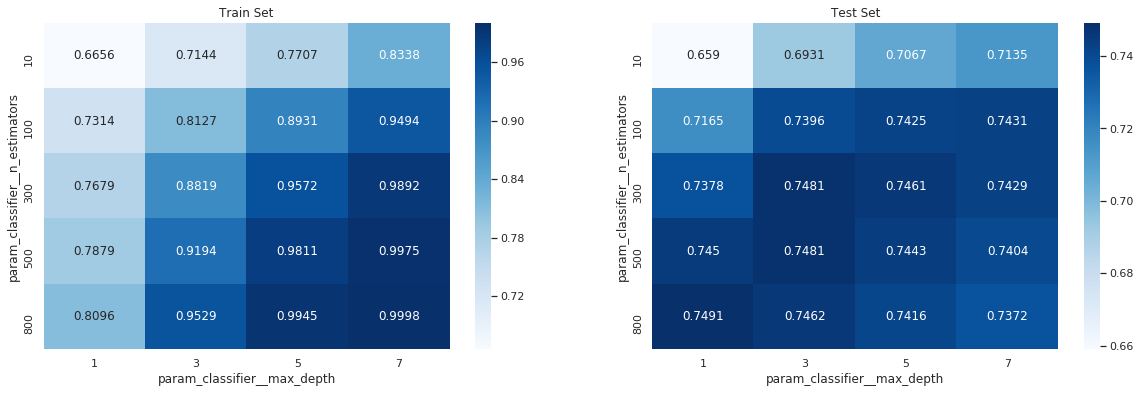

In [0]:
#Heatmaps
sns.set()
max_scores1 = pd.DataFrame(gs.cv_results_).groupby(['param_classifier__n_estimators', 'param_classifier__max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0], cmap = 'Blues')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1], cmap = 'Blues')
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

We can see that the model is definitely overfitting with higher depth, so now we'll keep the depth low with play around with more n_estimators

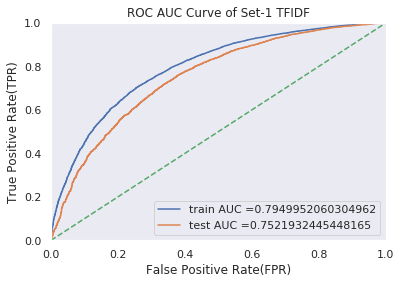

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
roc_auc_pipe(gs.best_estimator_, X_train, X_test, y_train, y_test, "ROC AUC Curve of Set-1 TFIDF")

<p style="text-align: center;"> This is a confusion matrix when I ran the best model without scaled_pos_weights </p>

![image.png](attachment:image.png)

The test AUC of 0.75 seems good, as I've seen scores around the mark of 0.69-0.73 for most cases using XGBoost on this dataset. 

This might be because the use of pipeline. Also, without using scale_pos_weight also resulted in a similar score.

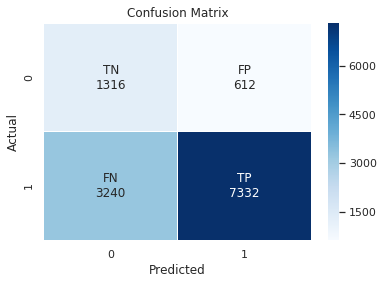

In [0]:
# https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
y_pred = gs.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_mat,  annot=labels,  cmap = 'Blues', fmt = '', linewidths=.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix');

We can see that the TN saw a terrific increase from 89 to 1316

## Setting depth low and increasing n_estimators

In [0]:
%%time
num_folds = 3
cv = StratifiedKFold(n_splits=num_folds, random_state =seed)
param_grid = {
    'classifier__max_depth': [1, 2, 3],
    'classifier__n_estimators': [500, 800, 1200, 1800]
}

gs2 = GridSearchCV(pipeline, param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1,\
                  verbose=7, return_train_score = True, refit = True)

gs2 = gs2.fit(X_train, y_train)
print(("best score from grid search: %.3f"
       % gs.best_score_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  36 | elapsed:  4.2min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:  7.1min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  23 out of  36 | elapsed: 10.1min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 13.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 20.2min finished


best score from grid search: 0.749
CPU times: user 3min 36s, sys: 476 ms, total: 3min 36s
Wall time: 23min 49s


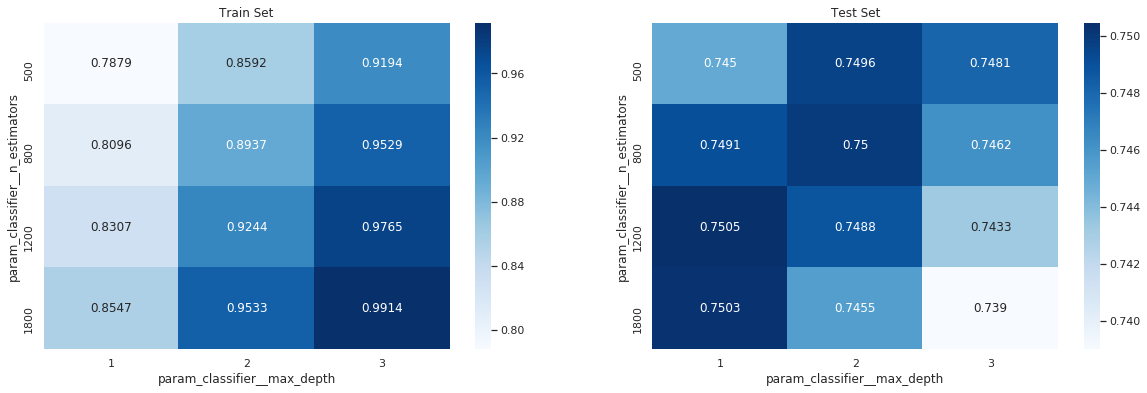

In [0]:
#Heatmaps
sns.set()
max_scores = pd.DataFrame(gs2.cv_results_).groupby(['param_classifier__n_estimators', 'param_classifier__max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0], cmap = 'Blues')
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1], cmap = 'Blues')
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

Here we can clearly see that the model is overfitting with increase in depth and n_estimators

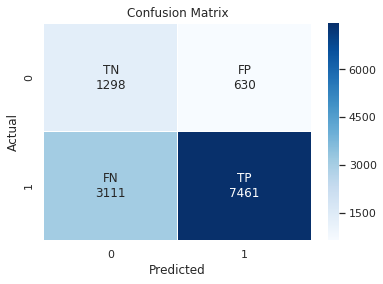

In [0]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

y_pred = gs2.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_mat,  annot=labels,  cmap = 'Blues', fmt = '', linewidths=.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix');

As we can see here we've increased the TN and decreased the FP.

The best classifier seems to be witth depth 1 and n_estimators 500, with train AUC 0.78 and test AUC 0.7503.

Although depth 2, n_estimators 800 has higher AUC of 0.75 but it also has much higher train AUC of 0.89, that's why we haven't selected it.

## **Improving the model further**

In [0]:
%%time
#https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101
num_folds = 3
cv = StratifiedKFold(n_splits=num_folds, random_state =seed)
param_grid = {
    'classifier__max_depth': [1],
    'classifier__n_estimators': [1000]
}

gs3 = GridSearchCV(pipeline, param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1,\
                  verbose = 5, return_train_score = True, refit = True)

fit_params={"classifier__early_stopping_rounds": 20, 
            "classifier__eval_metric" : ["error","auc"],
            "classifier__verbose" : False,
            "classifier__eval_set" : [[X_train, y_train],[X_test, y_test]]}
            
gs3 = gs3.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


CPU times: user 2min 35s, sys: 604 ms, total: 2min 36s
Wall time: 4min 17s


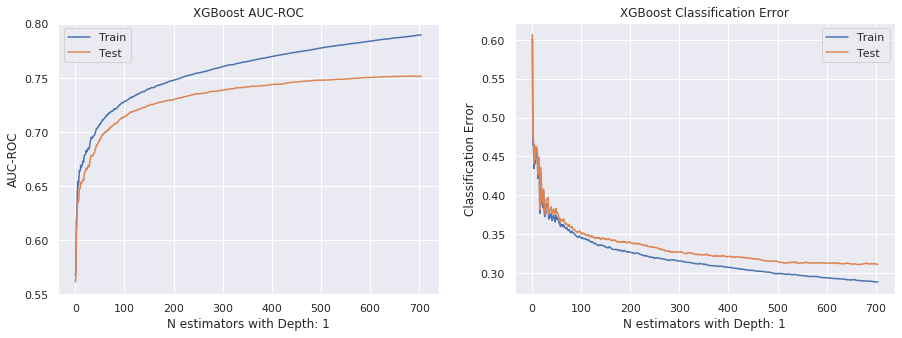

In [0]:
# retrieve performance metrics
results = gs3.best_estimator_.named_steps['classifier'].evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
depth = gs3.param_grid['classifier__max_depth'][0]
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators with Depth: {0}'.format(depth))

# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators with Depth: {0}'.format(depth))

plt.show()

As we can see from the plots, the train scores and test scores go up and down simultaneously.

We can stop the training at around 500 n_estimators mark for depth = 1, this'll get us an AUC around 0.75

In [0]:
pred_train = gs3.predict(X_train)
pred_test = gs3.predict(X_test)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))

print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.7102133333333334
Test Accuraccy:  0.68768

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.69      0.40      1928
           1       0.92      0.69      0.79     10572

    accuracy                           0.69     12500
   macro avg       0.60      0.69      0.60     12500
weighted avg       0.83      0.69      0.73     12500



# TFIDF-W2V

### Set 2: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

### TFIDF W2V - preprocessed_essays

In [0]:
open("glove_vectors","rb")
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

def tfidf_w2v(preprocessed_data):
    tfidf_model = TfidfVectorizer(stop_words = 'english', min_df = 10)
    tfidf_model.fit(preprocessed_data)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    # average Word2Vec
    # compute average word2vec for each review.
    tfidf_w2v_data = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm_notebook(preprocessed_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_data.append(vector)
    
    return tfidf_w2v_data

In [0]:
%%time
preprocessed_essays = data['essay'].values
tfidf_w2v_essays = tfidf_w2v(preprocessed_essays)


CPU times: user 1min 44s, sys: 982 ms, total: 1min 45s
Wall time: 1min 44s


### TFIDF W2V - preprocessed_titles

In [0]:
%%time
preprocessed_titles = data['project_title'].values
tfidf_w2v_titles = tfidf_w2v(preprocessed_titles)


CPU times: user 654 ms, sys: 60.4 ms, total: 714 ms
Wall time: 700 ms


## Concatenating all features

In [0]:
tfidf_w2v_essays_dataframe = pd.DataFrame(tfidf_w2v_essays)
tfidf_w2v_titles_dataframe = pd.DataFrame(tfidf_w2v_titles)

In [0]:
tfidf_w2v_data = data.drop(['project_title','project_resource_summary', 'essay'], axis =1)

In [0]:
X_tfidfw2v = tfidf_w2v_data.drop('project_is_approved', axis =1)
y_tfidfw2v = tfidf_w2v_data['project_is_approved'].values

In [0]:
numeric_features = ['teacher_number_of_previously_posted_projects', 'price']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = ['school_state', 'teacher_prefix', 'project_grade_category','project_subject_categories','project_subject_subcategories']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)]
    ,n_jobs=-1, verbose=True, remainder = 'passthrough'
            )

In [0]:
X_encoded_tfidfw2v = preprocessor.fit_transform(X_tfidfw2v)

In [0]:
%%time

X_tfidf_w2v_encoded = hstack((X_encoded_tfidfw2v ,tfidf_w2v_essays_dataframe ,tfidf_w2v_titles_dataframe)).tocsr()
print(X_tfidf_w2v_encoded.shape)#Now we have a full prediction pipeline.

(50000, 1101)
CPU times: user 1.32 s, sys: 409 ms, total: 1.73 s
Wall time: 1.73 s


In [0]:
%%time
seed = 42
y_set2 = data['project_is_approved'].values
X_set2 = X_tfidf_w2v_encoded

model = XGBClassifier(objective = 'binary:logistic',
                      random_state = seed, 
                      eval_metric = ["error","auc"],
                      verbosity = 1,
                     scale_pos_weight = scale_pos_weight)
clf_set2 = Pipeline(steps=[('classifier',  model)])
X_train_set2, X_test_set2, y_train_set2, y_test_set2 = train_test_split(X_set2, y_set2, test_size=0.25, stratify=y, shuffle=True)
clf_set2 = clf_set2.fit(X_train_set2, y_train_set2)

CPU times: user 1min 56s, sys: 864 ms, total: 1min 57s
Wall time: 1min 57s


In [0]:
#model assessment
pred_test_set2 = clf_set2.predict(X_test_set2)
pred_train_set2 = clf_set2.predict(X_train_set2)
print('Train Accuracy: ', accuracy_score(y_train_set2, pred_train_set2))
print('Test Accuraccy: ', accuracy_score(y_test_set2, pred_test_set2))
print('Classification Report:')
print(classification_report(y_test_set2,pred_test_set2))

Train Accuracy:  0.6979733333333333
Test Accuraccy:  0.67576
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.62      0.37      1929
           1       0.91      0.69      0.78     10571

    accuracy                           0.68     12500
   macro avg       0.59      0.65      0.58     12500
weighted avg       0.81      0.68      0.72     12500



In [0]:
%%time 
param_grid = {
    'classifier__max_depth': [1, 2, 3, 4],
    'classifier__n_estimators': [10, 100, 300, 500]
}

gs_tfidf = GridSearchCV(clf_set2, param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1,\
                  verbose = 5 , return_train_score = True, refit = True)

best_gs_tfidf = gs_tfidf.fit(X_train_set2, y_train_set2)
print(("best classifier from grid search: %.3f"
       % gs_tfidf.score(X_test_set2, y_test_set2)))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:  4.8min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  37 out of  48 | elapsed:  8.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 16.9min finished


best classifier from grid search: 0.717
CPU times: user 3min 45s, sys: 1.1 s, total: 3min 46s
Wall time: 20min 37s


In [0]:
report(best_gs_tfidf.cv_results_)

Model with rank: 1
Mean test score: 0.71473483 (std: 0.00193402)
Parameters: {'classifier__max_depth': 2, 'classifier__n_estimators': 300}

Model with rank: 2
Mean test score: 0.71402424 (std: 0.00230081)
Parameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 500}

Model with rank: 3
Mean test score: 0.71380267 (std: 0.00246041)
Parameters: {'classifier__max_depth': 2, 'classifier__n_estimators': 500}

Model with rank: 4
Mean test score: 0.71167733 (std: 0.00169678)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 300}

Model with rank: 5
Mean test score: 0.71130543 (std: 0.00142565)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 100}



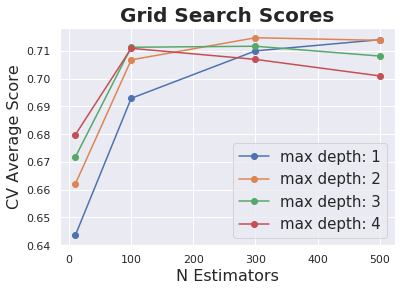

In [0]:
max_depth = best_gs_tfidf.param_grid['classifier__max_depth']
n_estimators = best_gs_tfidf.param_grid['classifier__n_estimators']
plot_grid_search(best_gs_tfidf.cv_results_, n_estimators, max_depth, 'N Estimators', 'max depth')

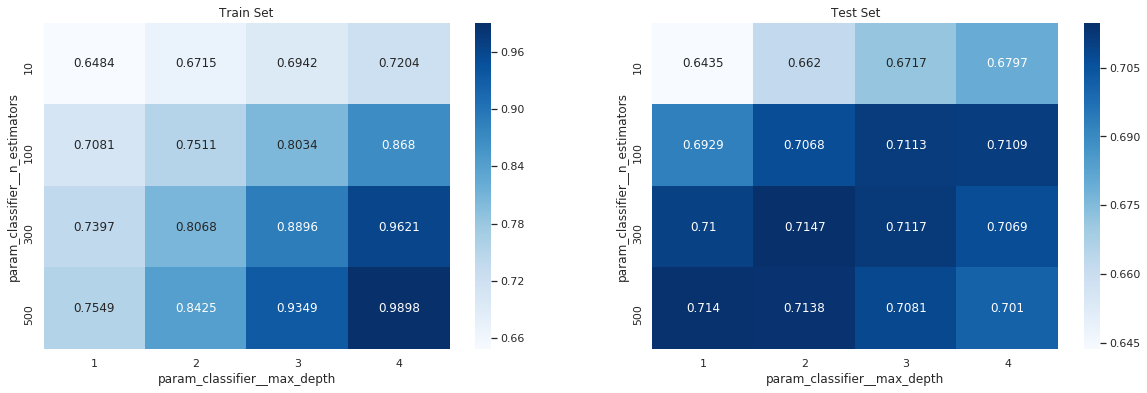

In [0]:
#Heatmaps
sns.set()
max_scores = pd.DataFrame(best_gs_tfidf.cv_results_).groupby(['param_classifier__n_estimators', 'param_classifier__max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0], cmap = 'Blues')
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1], cmap = 'Blues')
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show();

In [0]:
%%time
best_model = XGBClassifier(objective = 'binary:logistic',
                           random_state = seed, 
                           eval_metric = ["error","auc"],
                           verbosity = 1,
                           scale_pos_weight = scale_pos_weight,
                           max_depth = 4,
                           n_estimators = 500)
best_model = best_model.fit(X_train_set2, y_train_set2)

CPU times: user 11min 50s, sys: 889 ms, total: 11min 51s
Wall time: 11min 51s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['error', 'auc'], gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.1824244430780873, seed=None,
              silent=None, subsample=1, verbosity=1)

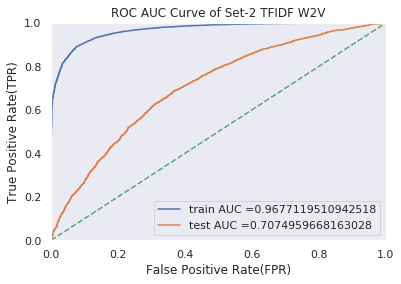

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
roc_auc_pipe(best_model, X_train_set2, X_test_set2, y_train_set2, y_test_set2, "ROC AUC Curve of Set-2 TFIDF W2V")

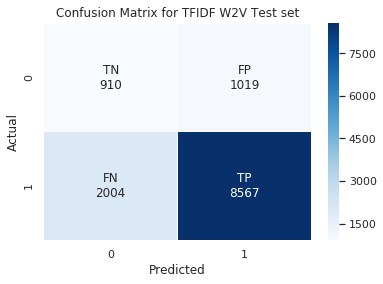

In [0]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

y_pred = best_model.predict(X_test_set2)
conf_mat = confusion_matrix(y_test_set2, y_pred)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_mat,  annot=labels,  cmap = 'Blues', fmt = '', linewidths=.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for TFIDF W2V Test set')
plt.show()

### Now let's do this with categorical encoding as response coding

In [0]:
%%time
rc = response_coding_transformer(categorical_features)
rc.fit(X_tfidfw2v, y_tfidfw2v)
X_set2_resp = rc.transform(X_tfidfw2v)

CPU times: user 3min 30s, sys: 63.1 ms, total: 3min 30s
Wall time: 3min 28s


In [0]:
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)]
    ,n_jobs=-1, verbose=True, remainder = 'passthrough'
            )

In [0]:
%%time
X_encoded_tfidfw2v_resp = preprocessor.fit_transform(X_set2_resp)

CPU times: user 1.46 s, sys: 433 ms, total: 1.89 s
Wall time: 1.37 s


In [0]:
%%time
X_tfidf_w2v_encoded_resp = hstack((X_encoded_tfidfw2v_resp ,tfidf_w2v_essays_dataframe ,tfidf_w2v_titles_dataframe)).tocsr()
print(X_tfidf_w2v_encoded_resp.shape)#Now we have a full prediction pipeline.

(50000, 617)
CPU times: user 4.26 s, sys: 365 ms, total: 4.63 s
Wall time: 1.3 s


In [0]:
%%time
seed = 42
y_set2 = data['project_is_approved'].values
X_set2_resp = X_tfidf_w2v_encoded_resp

model = XGBClassifier(objective = 'binary:logistic',
                      random_state = seed, 
                      eval_metric = ["error","auc"],
                      verbosity = 1,
                     scale_pos_weight = scale_pos_weight)
clf_set2_resp = Pipeline(steps=[('classifier',  model)])
X_train_set2_resp, X_test_set2_resp, y_train_set2, y_test_set2 = train_test_split(X_set2_resp, y_set2, test_size=0.25, stratify=y, shuffle=True)
clf_set2_resp = clf_set2_resp.fit(X_train_set2_resp, y_train_set2)

CPU times: user 2min 29s, sys: 638 ms, total: 2min 30s
Wall time: 2min 30s


In [0]:
#model assessment
pred_test_set2 = clf_set2_resp.predict(X_test_set2_resp)
pred_train_set2 = clf_set2_resp.predict(X_train_set2_resp)
print('Train Accuracy: ', accuracy_score(y_train_set2, pred_train_set2))
print('Test Accuraccy: ', accuracy_score(y_test_set2, pred_test_set2))
print('Classification Report:')
print(classification_report(y_test_set2, pred_test_set2))

Train Accuracy:  0.7052
Test Accuraccy:  0.6864
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.66      0.39      1929
           1       0.92      0.69      0.79     10571

    accuracy                           0.69     12500
   macro avg       0.60      0.67      0.59     12500
weighted avg       0.82      0.69      0.73     12500



In [0]:
#Save all variables and models so you don't compute them again, you idiot

In [0]:
best_model = load('best_model_TFIDF.joblib')
clf_set2_resp= load('clf_set2_resp.joblib')

In [0]:
param_grid = {
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__n_estimators': [10, 100, 300, 500, 800]
}

gs_tfidf_resp = GridSearchCV(clf_set2_resp, param_grid, cv = cv, scoring = 'roc_auc', n_jobs = -1,\
                  verbose = 5 , return_train_score = True, refit = True)

%time best_gs_tfidf_resp = gs_tfidf_resp.fit(X_train_set2_resp, y_train_set2)

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 37 µs


In [0]:
print(("best classifier from grid search: %.3f"
       % best_gs_tfidf_resp.score(X_test_set2_resp, y_test_set2)))

best classifier from grid search: 0.737


In [0]:
report(best_gs_tfidf_resp.cv_results_)

Model with rank: 1
Mean test score: 0.72771366 (std: 0.00266004)
Parameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 800}

Model with rank: 2
Mean test score: 0.72603092 (std: 0.00305883)
Parameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 500}

Model with rank: 3
Mean test score: 0.72336551 (std: 0.00476815)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 300}

Model with rank: 4
Mean test score: 0.72263340 (std: 0.00275785)
Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}

Model with rank: 5
Mean test score: 0.72216682 (std: 0.00411484)
Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 100}



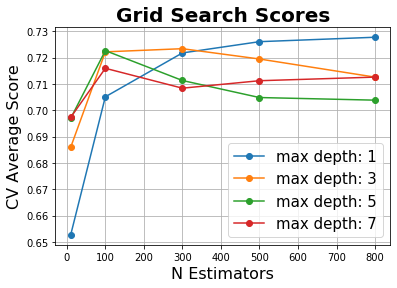

In [0]:
max_depth = best_gs_tfidf_resp.param_grid['classifier__max_depth']
n_estimators = best_gs_tfidf_resp.param_grid['classifier__n_estimators']
plot_grid_search(best_gs_tfidf_resp.cv_results_, n_estimators, max_depth, 'N Estimators', 'max depth')

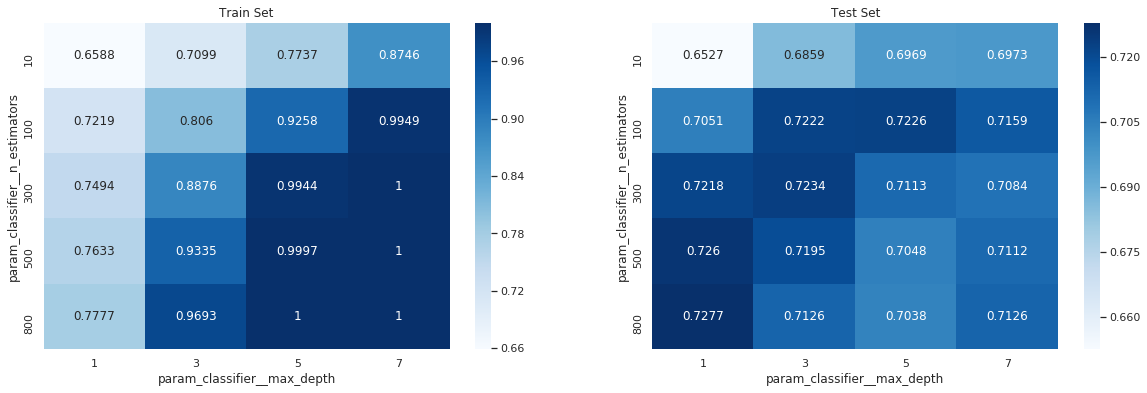

In [0]:
#Heatmaps
sns.set()
max_scores = pd.DataFrame(best_gs_tfidf_resp.cv_results_).groupby(['param_classifier__n_estimators', 'param_classifier__max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0], cmap = 'Blues')
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1], cmap = 'Blues')
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

With high n_estmators classifier with depth 1 is performing best without too much overfitting

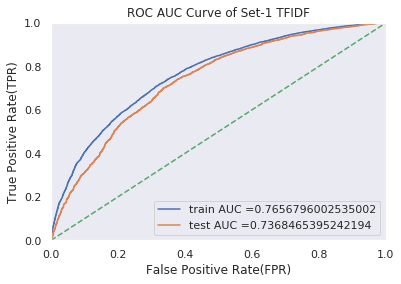

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
roc_auc_pipe(best_gs_tfidf_resp.best_estimator_, X_train_set2_resp, X_test_set2_resp, y_train_set2, y_test_set2, "ROC AUC Curve of Set-1 TFIDF")

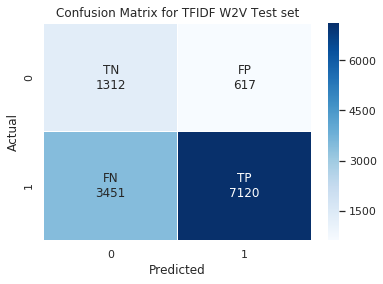

In [0]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

y_pred_set2_resp = best_gs_tfidf_resp.best_estimator_.predict(X_test_set2_resp)
conf_mat = confusion_matrix(y_test_set2, y_pred_set2_resp)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_mat,  annot=labels,  cmap = 'Blues', fmt = '', linewidths=.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for TFIDF W2V Test set')
plt.show()

## Summary

In [0]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Max depth","N estimatior", "AUC"]
x.add_row(["XGBoost TFIDF", 1, 500, 0.761])
x.add_row(["XGBoost TFIDF W2V", 1, 800, 0.736])
print(x)

+-------------------+-----------+--------------+-------+
|     Vectorizer    | Max depth | N estimatior |  AUC  |
+-------------------+-----------+--------------+-------+
|   XGBoost TFIDF   |     1     |     500      | 0.761 |
| XGBoost TFIDF W2V |     4     |     500      | 0.736 |
+-------------------+-----------+--------------+-------+
